## Fit the Prophet Model 

In [2]:
import os
import pandas as pd 
from prophet import Prophet
import matplotlib.pyplot as plt
from pathlib import Path

script_dir = Path.cwd()
data_dir = script_dir.parent / "data"
file_path = data_dir / "cleaned_data2.csv"
df = pd.read_csv(file_path)

df["DateReported"] = pd.to_datetime(df["DateReported"], errors="coerce", utc=True)
df_weekly = df.resample("W", on="DateReported").size().reset_index()
df_weekly = df_weekly.rename(columns={"DateReported": "ds", 0: "y"})
df_weekly["ds"] = df_weekly["ds"].dt.tz_localize(None)
df_weekly = df_weekly.sort_values("ds")

# Define UVA holidays 
uva_holidays = []
start_year, end_year = 2019, 2023

for year in range(start_year, end_year + 1):
    uva_holidays.extend([
        {"holiday": "Fall semester start", "ds": f"{year}-08-24"},
        {"holiday": "Fall semester end", "ds": f"{year}-12-06"},
        {"holiday": "Winter break start", "ds": f"{year}-12-07"},
        {"holiday": "Winter break end", "ds": f"{year}-01-17"},
        {"holiday": "Spring semester start", "ds": f"{year}-01-18"},
        {"holiday": "Spring semester end", "ds": f"{year}-05-02"},
        {"holiday": "Summer break start", "ds": f"{year}-05-03"},
        {"holiday": "Summer break end", "ds": f"{year}-08-23"},
    ])

# Convert holidays to DataFrame with window effects
uva_holidays = pd.DataFrame(uva_holidays)
uva_holidays["ds"] = pd.to_datetime(uva_holidays["ds"])
uva_holidays["lower_window"] = uva_holidays["holiday"].apply(lambda x: -5 if "break" in x else -2)
uva_holidays["upper_window"] = uva_holidays["holiday"].apply(lambda x: 5 if "break" in x else 2)

# Initialize Prophet model with holidays
model2 = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    holidays=uva_holidays  # Incorporate UVA holidays
)

# Fit model
df_weekly["ds"] = pd.to_datetime(df_weekly["ds"]).dt.tz_localize(None)
model2.fit(df_weekly)

# Make future predictions
future2 = model2.make_future_dataframe(periods=104, freq="W")
forecast2 = model2.predict(future2)

# Display forecast
forecast2[["ds", "yhat", "yhat_lower", "yhat_upper"]].head()

/var/folders/r9/vr40l1ss0v71ty4xxtt_10j00000gn/T/ipykernel_36506/633666853.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["DateReported"] = pd.to_datetime(df["DateReported"], errors="coerce", utc=True)
13:55:44 - cmdstanpy - INFO - Chain [1] start processing
13:55:44 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
0,2019-10-06,75.842112,55.198566,95.071033
1,2019-10-13,80.626253,61.956297,98.780725
2,2019-10-20,89.593809,72.215613,109.118717
3,2019-10-27,94.106372,74.812875,113.591531
4,2019-11-03,89.663119,70.583880,109.187843


# Create Output

## Forecast Visualizations

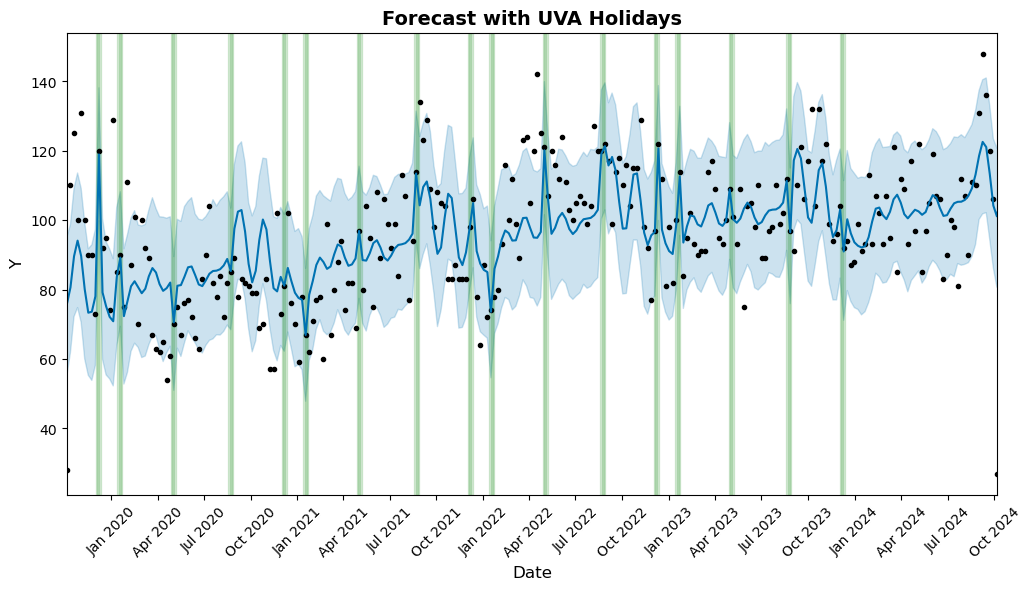

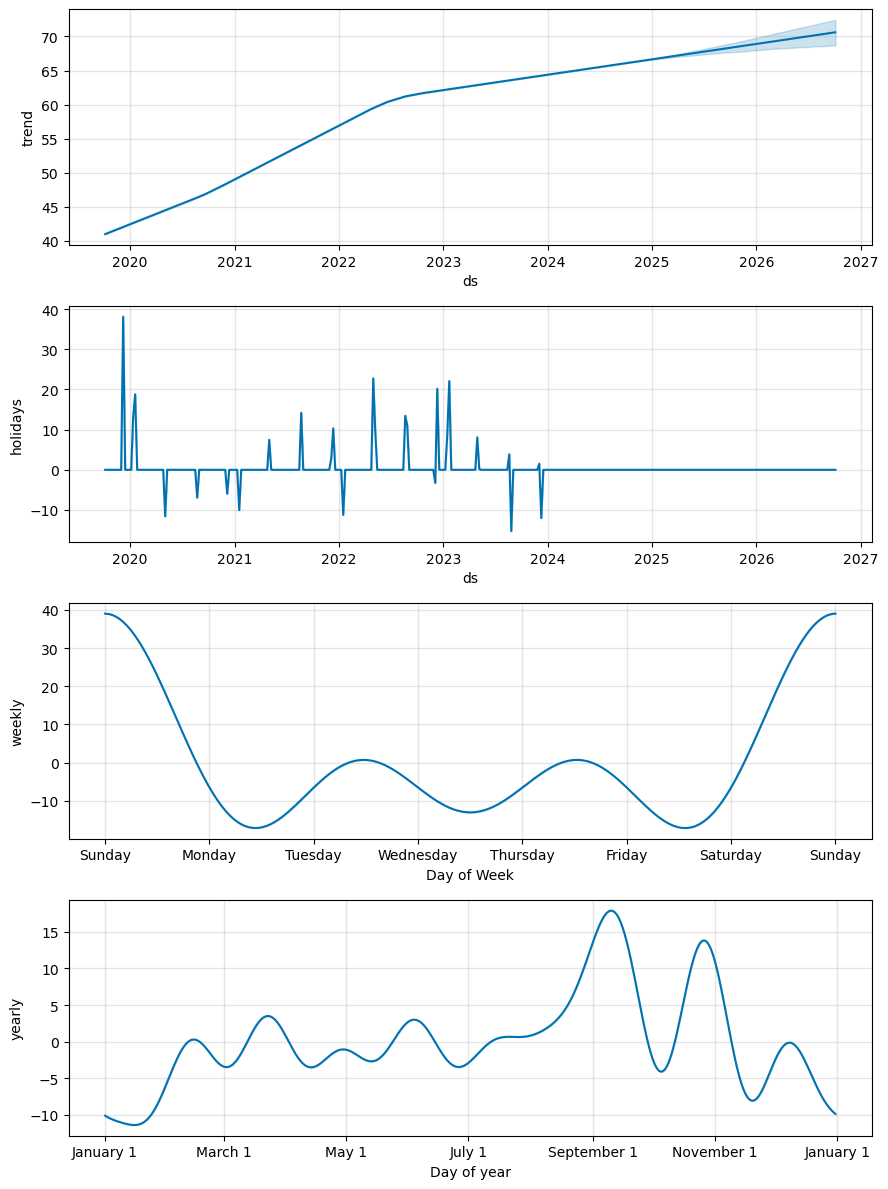

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Define the cutoff date for plotting
cutoff_date = pd.Timestamp("2019-10-06")

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))


model2.plot(forecast2, ax=ax)
ax.get_lines()[0].set_linewidth(2)  

ax.set_xlim([cutoff_date, df_weekly["ds"].max()])

# Shade holidays
for _, row in uva_holidays.iterrows():
    holiday_start = row["ds"] + pd.Timedelta(days=row["lower_window"])
    holiday_end = row["ds"] + pd.Timedelta(days=row["upper_window"])
    
    if holiday_end >= cutoff_date:
        ax.axvspan(holiday_start, holiday_end, color="green", alpha=0.15)  # Softer shading

ax.get_children()[-1].set_alpha(0.6)  # Reduce opacity of scatter points

# Format x-axis labels for every 6 months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Every 3 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format as "Jan 2021", "Jul 2021"

plt.xticks(rotation=45)

ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Y", fontsize=12)
ax.set_title("Forecast with UVA Holidays", fontsize=14, fontweight="bold")

# Show the plot
ax.grid(False) # Hide grid lines
plt.show()

# Plot seasonality components
fig2 = model2.plot_components(forecast2)
plt.show()


### Conclusions 
1. In the next year (2024), our model predicts that crime will increase, spiking in the fall months when UVA is in session. 
2. Crime slightly plateud around July 2022 but then continued to increase steadily in 2023. Our model predicts that this increase will continue though 2024 to 2026. 
3. Our model shows sharp increases in crime during the weekend and less crime on Mondays and Fridays. There is moderate crime Tuesday through Thursday. 
4. On a yearly cycle, crime tends to peak in early September (students coming back to school) and then fall around October (students leaving for fall break). We also see a steep decrease in crime beginning in mid-December and lasting through early February. This coincides with when students are on winter break. 

## Model Evaluation

In [6]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error

# Validation 
# Split dataset for validation
train_size = int(len(df_weekly) * 0.8)
train, test = df_weekly.iloc[:train_size], df_weekly.iloc[train_size:]

# Initialize new Prophet model for validation
model_val2 = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    holidays=uva_holidays  # Include holidays in validation model
)

# Fit model on training set
model_val2.fit(train)

# Predict on test set
test_forecast2 = model_val2.predict(test)

# Evaluate model
mae2 = mean_absolute_error(test["y"], test_forecast2["yhat"])
rmse2 = root_mean_squared_error(test["y"], test_forecast2["yhat"])
mape2 = mean_absolute_percentage_error(test["y"], test_forecast2["yhat"])

print(f"\nMAE: {mae2}")
print(f"RMSE: {rmse2}")
print(f"MAPE: {mape2}")


14:11:25 - cmdstanpy - INFO - Chain [1] start processing
14:11:25 - cmdstanpy - INFO - Chain [1] done processing



MAE: 11.820485635491181
RMSE: 17.310910064515372
MAPE: 0.16044533874170602
